In [8]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

In [9]:
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)
#Set parameters
#pixel_scale = 0.1 #as/px
lamda = 800 #nm
diameter = 1.2 #m
psf_oversample = 5.
gal_oversample = 1.
interpolant = 'lanczos100' #sinc #lanczosN #quintic


In [10]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
sersicfit = cc.param_cat['sersicfit']
hlr, sn, q, phi = [sersicfit[:,i] for i in (1,2,3,7)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][400:405] #Large galaxies, reasonable sersic n
gals = sm.makeGalaxy(cc,small100I, chromatic=False, gsparams=gsparams,trunc_factor=0.0)

intrinsicAngles = phi[small100I]
targetTheta = np.radians(0)

rotGalVec = np.vectorize(sm.rotGal)
rotGals = rotGalVec(gals,intrinsicAngles,targetTheta)#(nrot, ngals)

hlrcut, sncut, qcut = hlr[small100I], sn[small100I], q[small100I] #Not safe with bulges, but there are none at the moment

galShiftErrsVec = np.vectorize(sm.galShiftErrs,otypes=[object,object], excluded=set([1,2,3,'measureShape','psfii','gsparams', 'interpolant']))


In [11]:
def gete(q,b):
    shear = galsim.shear.Shear(q=q, beta=b*galsim.radians)
    return np.array([shear.e1, shear.e2])
q0 = q[small100I]
shearVec = np.vectorize(gete, otypes=[object])
trueShears = shearVec(q0, targetTheta)
trueShears = np.stack([np.stack(x) for x in trueShears]) #(ngals, (e1, e2))

In [12]:
pslist = np.arange(0.05,0.11,0.01)
#pslist=[0.1]
nx = 4  # 5


In [13]:
sh=trueShears.shape
trueShearsExt = trueShears.reshape((1,sh[0],sh[1]))
trueShearsExt = np.repeat(trueShearsExt,len(pslist),axis=0)
trueShearsExt = trueShearsExt.transpose(0,2,1)

In [14]:
reconvList, origList = [],[]
for pixel_scale in pslist:
    print pixel_scale
    # Make epsf, draw epsf image, interpolated image
    airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
    pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
    psf = galsim.Convolve(airy, pixel)
    given_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image
    psf_galsample = psf.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel') #Draw at galaxy scale for shape measurement
    psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams,x_interpolant=interpolant)
    
    ss = pixel_scale / gal_oversample

    reconv = galShiftErrsVec(rotGals, psf, nx, ss, sm.measureShapeReconv, psfii, interpolant, gsparams)
    orig= galShiftErrsVec(rotGals,psf,nx,ss)

    reconv = np.stack([np.stack([np.stack(x) for x in a]) for a in reconv])
    orig = np.stack([np.stack([np.stack(x) for x in a]) for a in orig])
    reconvList.append(reconv); origList.append(orig)
reconv = np.stack(reconvList) #pixel_scale, (e1, e2), ngal, movedCenter
orig= np.stack(origList)


0.05
0.060000000000000005
0.07
0.08000000000000002
0.09000000000000001
0.1


In [15]:
origMean, origStd = np.nanmean(orig,axis=-1), np.nanstd(orig,axis=-1)
reconvMean, reconvStd = np.nanmean(reconv, axis=-1), np.nanstd(reconv, axis=-1)
recOrigDiff = reconv - orig
recOrigDiffMean, recOrigDiffStd = np.nanmean(recOrigDiff, axis=-1), np.nanstd(recOrigDiff, axis=-1)


diffShapes = np.stack([origMean - trueShearsExt, reconvMean - trueShearsExt, recOrigDiffMean]).transpose(0,2,3,1)
diffShapesErr = np.stack([origStd, reconvStd, recOrigDiffStd]).transpose(0,2,3,1)

In [16]:
diffShapes.shape #(., (e1, e2), ngal, ps)

(3, 2, 5, 6)

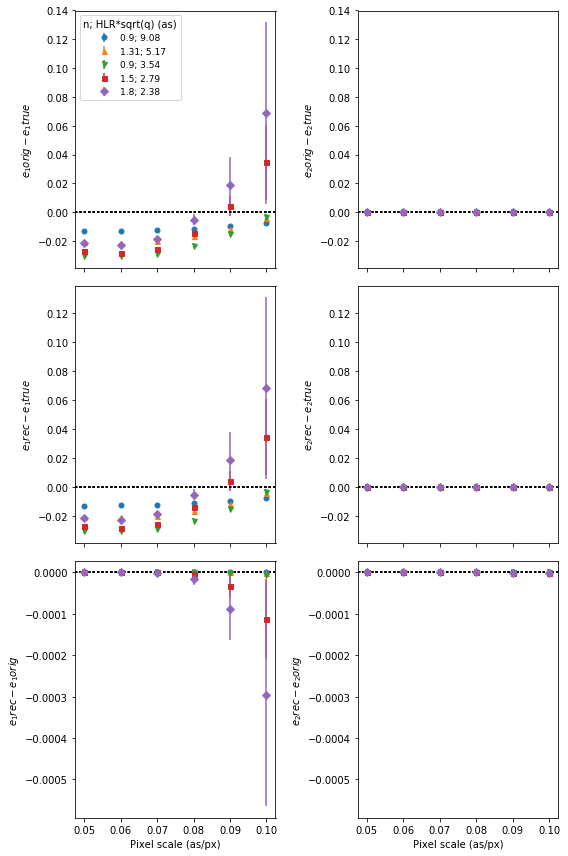

In [17]:
order = np.argsort(hlrcut*np.sqrt(qcut))[::-1] #Descending order of circularized hlr
labels=['%s; %s' % (snl,hlrc) for (snl,hlrc) in zip(np.round(sncut,2)[order], np.round(hlrcut*qcut,2)[order])]
markers=['o','^','v','s','D']
orderedDiffShapes = diffShapes[:,:,order,:]
orderedDiffShapeErrs = diffShapesErr[:,:,order,:]
fig,ax = plt.subplots(3,2,figsize = (8,12),sharex = True)
names = np.array([['$e_1orig - e_1true$','$e_1rec - e_1true$', '$e_1rec - e_1orig$'],\
                  ['$e_2orig - e_2true$','$e_2rec - e_2true$', '$e_2rec - e_2orig$']]).transpose()
for i in range(3): # orig-true; rec-true; rec-orig
    for j in range(2): #e1, e2
        sp = orderedDiffShapes[i,j]
        for galnum,spp in enumerate(sp): #galaxies
            name=names[i,j]
            subax=ax[i,j]
            subax.errorbar(pslist, spp, yerr=orderedDiffShapeErrs[i,j,galnum], \
                           fmt='.',label=labels[galnum],marker=markers[galnum],markersize=5)#label='Gal %d'%(galnum))
            #subax.axhline(0.0,c='k',linestyle=':')
            if i==2: subax.set_xlabel('Pixel scale (as/px)')
            subax.set_ylabel(name)
            #subax.legend()
            subax.axhline(0.0,c='k',linestyle=':')
ax[0,0].legend(loc='upper left',title='n; HLR*sqrt(q) (as)',fontsize=9)

def matchylim(axList):
    ylList = ([sa.get_ylim()[0] for sa in axList], [sa.get_ylim()[1] for sa in axList])
    yl = (min(ylList[0]), max(ylList[1]))
    return yl
for i in range(3):
    yl1 = matchylim(ax[i,:])
    for sa in ax[i,:]: sa.set_ylim(yl1)
    #ax[i,1].set_yticklabels([])



plt.tight_layout()

#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/reconvolve_bias_pixelsize_errs_00deg_800nm_lanczos100.pdf')